# Complete Machine with the environment Pillars & Walls + Contact forces + Motor control of turning + Backward Movement 

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import trange
from gymnasium.utils.env_checker import check_env
from IPython.display import Video
from enum import Enum, auto

from flygym.mujoco import Parameters
from flygym.mujoco.arena import FlatTerrain
from flygym.mujoco.examples.obstacle_arena import ObstacleOdorArena
from flygym.mujoco.examples.turning_controller import HybridTurningNMF

from scipy.signal import find_peaks
import pickle
from scipy.interpolate import interp1d
import flygym.mujoco


### Implement the Environment (here with pillars) 
> look out the 1_Environment.ipynb for more information

In [14]:
# We start by creating a arena with the flat terrain and some obstacles
flat_terrain_arena = FlatTerrain(friction=(1.75,0.005, 0.0001))

arena = ObstacleOdorArena(
    terrain=flat_terrain_arena,
    obstacle_positions=np.array([(7.5, 0), (13, 2.5), (12,7.5), (3.5,5), (17.5, 7.5), (7.5, 12.5)]),
    obstacle_colors=[(0.14, 0.14, 0.2, 1),(0.14, 0.14, 0.2, 1), (0.14, 0.14, 0.2, 1), (0.14, 0.14, 0.2, 1), (0.14, 0.14, 0.2, 1), (0.14, 0.14, 0.2, 1)],
    marker_size=0.5,
    # obstacle_colors=[(0.14, 0.14, 0.2, 1), (0.2, 0.8, 0.2, 1), (0.2, 0.2, 0.8, 1)],
    user_camera_settings=((13, -18, 9), (np.deg2rad(65), 0, 0), 45),
)

contact_sensor_placements = [
    f"{leg}{segment}"
    for leg in ["LF", "LM", "LH", "RF", "RM", "RH"]
    for segment in ["Tibia", "Tarsus1", "Tarsus2", "Tarsus3", "Tarsus4", "Tarsus5"]
]

run_time = 4
sim_params = flygym.mujoco.Parameters(
    timestep=1e-4, 
    render_mode="saved", 
    render_playspeed=0.1, 
    draw_contacts=False,
    render_camera="user_cam"
    # render_camera="Animat/camera_top"
)

nmf = HybridTurningNMF(
    sim_params=sim_params,
    init_pose="stretch",
    ############## 0.5 default of the Neuromechfly (0.2 for the TurningController)
    spawn_pos=(10, -5, 0.5),
    spawn_orientation=(0, 0, np.pi / 2 + np.deg2rad(80)),
    ###############
    contact_sensor_placements=contact_sensor_placements,
    arena=arena
)


### Implement the backward data
> look out the 4_Backward.ipynb for more information

In [15]:
actuated_joints = flygym.mujoco.preprogrammed.all_leg_dofs

data_path = flygym.common.get_data_path("flygym", "data")
with open(data_path / "behavior" / "210902_pr_fly1.pkl", "rb") as f:
    data = pickle.load(f)

target_num_steps = int(run_time / sim_params.timestep)
data_block = np.zeros((len(actuated_joints), target_num_steps))
input_t = np.arange(len(data["joint_LFCoxa"])) * data["meta"]["timestep"]
output_t = np.arange(target_num_steps) * sim_params.timestep
for i, dof in enumerate(actuated_joints):
    data_block[i, :] = np.interp(output_t, input_t, data[dof])

# get the joint angle of the right hind leg tibia
rh_tibia_angle = data_block[actuated_joints.index("joint_RHTibia")]

# ===============================================================================================
# TODO: detect peaks in the tibia angle of the right hind leg using scipy.signal.find_peaks
# see https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html for usage
peak_frame_indices = find_peaks(rh_tibia_angle)[0]
# ===============================================================================================

cycle_n_frames = round(np.diff(peak_frame_indices).mean())

data_block_cycle = np.zeros((len(actuated_joints), cycle_n_frames))

for a, b in np.lib.stride_tricks.sliding_window_view(peak_frame_indices, 2):
    old_indices = np.arange(b - a)
    new_indices = np.linspace(0, old_indices.max(), cycle_n_frames)
    data_block_cycle += interp1d(old_indices, data_block[:, a:b])(new_indices)

data_block_cycle /= len(peak_frame_indices) - 1

data_block_backwards = data_block_cycle.copy()
# data_block_backwards = data_block_backwards[:, ::-1]  # reverse the order of the frames

for i, (dof, angles) in enumerate(zip(actuated_joints, data_block_cycle)):
    # reassign the joint angles
    # (LF -> RH, RF -> LH, LM -> RM, RM -> LM, LH -> RF, RH -> LF)
    orig_dof = dof.translate(str.maketrans("LRFH", "RLHF"))[:8] + dof[8:]
    orig_angles = data_block_cycle[actuated_joints.index(orig_dof)]
    # rescale to match the range of the joint angles of that leg
    data_block_backwards[i] = (
        orig_angles - orig_angles.min()
    ) / orig_angles.ptp() * angles.ptp() + angles.min()


### Implement the Contact forces + Motor control of tuning 
> look out the 3_Contact_forces.ipynb and 4_Motor_Control for more information
> creation of the state machine

In [16]:
from enum import Enum, auto

# Random State Seed for Reproducibility (On the same machine)
seed = 1

# Definition of the states of the FSM
class State(Enum):
    GO_STRAIGHT = 1
    TURN_LEFT = 2
    TURN_RIGHT = 3
    REVERSE = 4

# Example of setting a current state
current_state = State.GO_STRAIGHT
next_state = State.GO_STRAIGHT

# Low Force Threshold: Turn
low_force_thresh = 2
# High Force Threshold: Need to Reverse
high_force_thresh = 5


enforce_time = 0
turn_delay = 200
reverse_delay = 1000

obs_hist = []
obs, _ = nmf.reset(seed)
bias = np.array([0,0])

for i in trange(int(run_time / nmf.sim_params.timestep)):
    curr_time = i
    # Front legs
    left_sense = np.array(obs["contact_forces"][:5, 0:2])
    right_sense = np.array(obs["contact_forces"][18:23, 0:2])
    left_sense_sum = np.abs(left_sense).sum()
    right_sense_sum = np.abs(right_sense).sum()
    
    # Middle legs
    left_sense_middle = np.array(obs["contact_forces"][6:11, 0:2])
    right_sense_middle = np.array(obs["contact_forces"][24:29, 0:2])
    left_sense_middle_sum = np.abs(left_sense_middle).sum()
    right_sense_middle_sum = np.abs(right_sense_middle).sum()

    orig = False

# Decision Making Process

    # (Default) State: Going Straight
    if current_state == State.GO_STRAIGHT:
        # Action: Go Straight
        control_signal = np.array([1, 1])
        # Using Unmodified Step Function (No Turning)
        orig = False

        #_______________________________________________________________________________________
        #_______________________________________________________________________________________
        # If High Force only Detected on Left Side
        if left_sense_sum > high_force_thresh or left_sense_middle_sum > high_force_thresh:
            print("High force detected on left side")
            current_state = State.REVERSE
            next_state = State.TURN_RIGHT
            enforce_time = curr_time + reverse_delay

        # If Low Force Detected on Left Side, NO REVERSE
        elif left_sense_sum > low_force_thresh or left_sense_middle_sum > low_force_thresh:
            print("Low force detected on left side")
            current_state = State.TURN_RIGHT
            enforce_time = curr_time + turn_delay

        # If High Force Detected only on Right Side
        elif right_sense_sum > high_force_thresh or right_sense_middle_sum > high_force_thresh:
            print("High force detected on right side")
            current_state = State.REVERSE
            next_state = State.TURN_LEFT
            enforce_time = curr_time + reverse_delay

        # If Low Force Detected on Right Side, NO REVERSE
        elif right_sense_sum > low_force_thresh or right_sense_middle_sum > low_force_thresh:
            print("Low force detected on right side")
            current_state = State.TURN_LEFT
            enforce_time = curr_time + turn_delay
        #_______________________________________________________________________________________
        #_______________________________________________________________________________________

    #_______________________________________________________________________________________
    #_______________________________________________________________________________________
    # State: Turning Right
    elif current_state == State.TURN_RIGHT:
        # activate the left leg only
        control_signal = np.array([1, 0])
        orig = False

        if left_sense_sum > high_force_thresh or left_sense_middle_sum > high_force_thresh:
            # resense the force on the left side, the fly is stuck --> reverse MORE
            current_state = State.REVERSE
            enforce_time = curr_time + reverse_delay

        elif left_sense_sum > low_force_thresh or left_sense_middle_sum > low_force_thresh:
            # resense the force on left side AGAIN --> turn MORE on right
            enforce_time = curr_time + turn_delay

        elif curr_time >= enforce_time:
            current_state = State.GO_STRAIGHT

    # State: Turning Left        
    elif current_state == State.TURN_LEFT:
        # activate the right leg only
        control_signal = np.array([0, 1])
        orig = False

        if right_sense_sum > high_force_thresh or right_sense_middle_sum > high_force_thresh:
            # resense the force on the right side, the fly is stuck --> reverse MORE
            current_state = State.REVERSE
            enforce_time = curr_time + reverse_delay

        elif right_sense_sum > low_force_thresh or right_sense_middle_sum > low_force_thresh:
            # resense the force on right side AGAIN --> turn MORE on left
            enforce_time = curr_time + turn_delay

        elif curr_time >= enforce_time:
            current_state = State.GO_STRAIGHT

    # State: Reversing       
    elif current_state == State.REVERSE:
        # print("Reversing")
        # control_signal = reverse_control_signal
        joint_pos = data_block_backwards[:, i % cycle_n_frames]
        control_signal = {"joints": joint_pos}
        orig = True
        # enforce_time = curr_time + reverse_delay
        
        if curr_time >= enforce_time:
            current_state = next_state

            # reset the enforce time for the turning
            enforce_time = curr_time + turn_delay

    if i > 1000:
        obs, reward, terminated, truncated, info = nmf.step(control_signal, orginal_action = orig)     
    else:
        obs, reward, terminated, truncated, info = nmf.step(np.array([0, 0]), orginal_action= False)
    
    obs_hist.append(obs)
    nmf.render()

nmf.save_video("./outputs/pillars.mp4")
Video("./outputs/pillars.mp4")

  5%|▍         | 1852/40000 [00:19<05:48, 109.45it/s]

Low force detected on left side


 27%|██▋       | 10654/40000 [01:37<04:34, 106.79it/s]

Low force detected on right side


 39%|███▉      | 15578/40000 [02:22<03:59, 101.83it/s]

Low force detected on right side


 42%|████▏     | 16600/40000 [02:35<04:06, 94.89it/s] 

High force detected on right side


 77%|███████▋  | 30771/40000 [05:29<01:18, 117.72it/s]

Low force detected on left side


 90%|████████▉ | 35995/40000 [06:19<00:39, 102.24it/s]

Low force detected on left side


 96%|█████████▌| 38367/40000 [06:44<00:17, 90.84it/s] 

Low force detected on left side


 99%|█████████▉| 39772/40000 [07:01<00:02, 99.10it/s] 

Low force detected on left side


100%|██████████| 40000/40000 [07:04<00:00, 94.33it/s] 


### Implement the Environment (here with walls) 
> look out the 1_Environment.ipynb for more information

In [17]:
# create for three walls
# Create a new class to generate 2 big walls next to the fly
from typing import Union, Tuple, List, Optional, Callable
from flygym.mujoco.arena import BaseArena, FlatTerrain, GappedTerrain, BlocksTerrain, MixedTerrain

class ObstacleWallsArena(BaseArena):
    num_sensors = 4

    def __init__(
        self,
        terrain: BaseArena,
        obstacle_positions: np.ndarray = np.array([(7.5, 0), (12.5, 5), (17.5, -5)]),
        obstacle_colors: Union[np.ndarray, Tuple] = (0, 0, 0, 1),
        obstacle_x: np.array = np.array([1, 1, 1]),
        obstacle_y: np.array = np.array([50, 50, 50]),
        obstacle_z: np.array = np.array([10, 10, 10]),

        obstacle_height: float = 4,
        odor_source: np.ndarray = np.array([[25, 0, 2]]),
        peak_intensity: np.ndarray = np.array([[1]]),
        diffuse_func: Callable = lambda x: x**-2,
        marker_colors: Optional[List[Tuple[float, float, float, float]]] = None,
        marker_size: float = 0.1,
        user_camera_settings: Optional[
            Tuple[Tuple[float, float, float], Tuple[float, float, float], float]
        ] = None,
    ):
        self.terrain_arena = terrain
        self.obstacle_positions = obstacle_positions
        self.root_element = terrain.root_element
        self.friction = terrain.friction
        self.obstacle_x = obstacle_x # largeur
        self.obstacle_y = obstacle_y # longeur
        self.obstacle_z = obstacle_z # hauteur

        z_offset = terrain.get_spawn_position(np.zeros(3), np.zeros(3))[0][2]
        obstacle_colors = np.array(obstacle_colors)
        if obstacle_colors.shape == (4,):
            obstacle_colors = np.array(
                [obstacle_colors for _ in range(obstacle_positions.shape[0])]
            )
        else:
            assert obstacle_colors.shape == (obstacle_positions.shape[0], 4)
        self.odor_source = np.array(odor_source)
        self.peak_odor_intensity = np.array(peak_intensity)
        self.num_odor_sources = self.odor_source.shape[0]
        if self.odor_source.shape[0] != self.peak_odor_intensity.shape[0]:
            raise ValueError(
                "Number of odor source locations and peak intensities must match."
            )
        self.odor_dim = self.peak_odor_intensity.shape[1]
        self.diffuse_func = diffuse_func

        # Add markers at the odor sources
        if marker_colors is None:
            rgb = np.array([255, 127, 14]) / 255
            marker_colors = [(*rgb, 1)] * self.num_odor_sources
            num_odor_sources = self.odor_source.shape[0]
        self.marker_colors = marker_colors
        self._odor_marker_geoms = []
        for i, (pos, rgba) in enumerate(zip(self.odor_source, marker_colors)):
            pos = list(pos)
            pos[2] += z_offset
            marker_body = self.root_element.worldbody.add(
                "body", name=f"odor_source_marker_{i}", pos=pos, mocap=True
            )
            geom = marker_body.add(
                "geom", type="capsule", size=(marker_size, marker_size), rgba=rgba
            )
            self._odor_marker_geoms.append(geom)

        # Reshape odor source and peak intensity arrays to simplify future claculations
        _odor_source_repeated = self.odor_source[:, np.newaxis, np.newaxis, :]
        _odor_source_repeated = np.repeat(_odor_source_repeated, self.odor_dim, axis=1)
        _odor_source_repeated = np.repeat(
            _odor_source_repeated, self.num_sensors, axis=2
        )
        self._odor_source_repeated = _odor_source_repeated
        _peak_intensity_repeated = self.peak_odor_intensity[:, :, np.newaxis]
        _peak_intensity_repeated = np.repeat(
            _peak_intensity_repeated, self.num_sensors, axis=2
        )
        self._peak_intensity_repeated = _peak_intensity_repeated

        # Add obstacles
        self.obstacle_bodies = []
        obstacle_material = self.root_element.asset.add(
            "material", name="obstacle", reflectance=0.1
        )
        self.obstacle_z_pos = z_offset + obstacle_height / 2
        for i in range(obstacle_positions.shape[0]):
            obstacle_pos = [*obstacle_positions[i, :], self.obstacle_z_pos]
            obstacle_color = obstacle_colors[i]
            obstacle_body = self.root_element.worldbody.add(
                "body", name=f"obstacle_{i}", mocap=True, pos=obstacle_pos
            )
            self.obstacle_bodies.append(obstacle_body)
            
            obstacle_body.add(
                "geom",
                type="box",
                size=(obstacle_x[i], obstacle_y[i], obstacle_z[i]),
                pos=(0, 0, 0),
                rgba=obstacle_color,
                material=obstacle_material,
                )
                

        # Add monitor cameras
        self.side_cam = self.root_element.worldbody.add(
            "camera",
            name="side_cam",
            mode="fixed",
            pos=(odor_source[0, 0] / 2, -25, 10),
            euler=(np.deg2rad(75), 0, 0),
            fovy=50,
        )
        self.back_cam = self.root_element.worldbody.add(
            "camera",
            name="back_cam",
            mode="fixed",
            pos=(-9, 0, 7),
            euler=(np.deg2rad(60), 0, -np.deg2rad(90)),
            fovy=55,
        )
        self.birdeye_cam = self.root_element.worldbody.add(
            "camera",
                    name="birdeye_cam",
            mode="fixed",
            pos=(7.5, 0, 25),
            euler=(0, 0, 0),
            fovy=45,
        )
        self.birdeye_cam_origin = self.root_element.worldbody.add(
            "camera",
            name="birdeye_cam_origin",
            mode="fixed",
            pos=(0, 0, 40),
            euler=(0, 0, 0),
            fovy=50,
        )
        if user_camera_settings is not None:
            cam_pos, cam_euler, cam_fovy = user_camera_settings
            self.root_element.worldbody.add(
                "camera",
                name="user_cam",
                mode="fixed",
                pos=cam_pos,
                euler=cam_euler,
                fovy=cam_fovy,
            )
        
    def get_spawn_position(
        self, rel_pos: np.ndarray, rel_angle: np.ndarray
    ) -> Tuple[np.ndarray, np.ndarray]:
        return self.terrain_arena.get_spawn_position(rel_pos, rel_angle)

    def get_olfaction(self, antennae_pos: np.ndarray) -> np.ndarray:
        antennae_pos_repeated = antennae_pos[np.newaxis, np.newaxis, :, :]
        dist_3d = antennae_pos_repeated - self._odor_source_repeated  # (n, k, w, 3)
        dist_euc = np.linalg.norm(dist_3d, axis=3)  # (n, k, w)
        scaling = self.diffuse_func(dist_euc)  # (n, k, w)
        intensity = self._peak_intensity_repeated * scaling  # (n, k, w)
        return intensity.sum(axis=0)  # (k, w)

    def pre_visual_render_hook(self, physics):
        for geom, rgba in zip(self._odor_marker_geoms, self.marker_colors):
            physics.bind(geom).rgba = np.array([*rgba[:3], 0])

    def post_visual_render_hook(self, physics):
        for geom, rgba in zip(self._odor_marker_geoms, self.marker_colors):
            physics.bind(geom).rgba = np.array([*rgba[:3], 1])

In [18]:
# We start by creating a arena with the flat terrain and walls
flat_terrain_arena = FlatTerrain()

# Then, we add walls features on top of it
arena = ObstacleWallsArena(
    terrain=flat_terrain_arena,
    obstacle_positions=np.array([(7.5, 0), (17.5, 0), (7.5, 15)]),
    obstacle_x = np.array([1, 1, 50]),
    obstacle_y = np.array([50, 50, 1]),
    obstacle_z = np.array([10, 10, 10]),
    marker_size=0.5,
    obstacle_colors=[(0.14, 0.14, 0.2, 1), (0.14, 0.14, 0.2, 1), (0.14, 0.14, 0.2, 1)],
    user_camera_settings=((13, -18, 9), (np.deg2rad(65), 0, 0), 45),
)

run_time = 2
sim_params = flygym.mujoco.Parameters(
    timestep=1e-4, 
    render_mode="saved", 
    render_playspeed=0.1, 
    draw_contacts=False,
    render_camera="user_cam"
    # render_camera="Animat/camera_top"
)

nmf = HybridTurningNMF(
    sim_params=sim_params,
    init_pose="stretch",
    ############## 0.5 default of the Neuromechfly (0.2 for the TurningController)
    spawn_pos=(10, -5, 0.5),
    spawn_orientation=(0, 0, np.pi + np.pi/2 ), # fly looks to the right front right
    ###############
    contact_sensor_placements=contact_sensor_placements,
    arena=arena
)

In [19]:
from enum import Enum, auto

# Random State Seed for Reproducibility (On the same machine)
seed = 1

# Definition of the states of the FSM
class State(Enum):
    GO_STRAIGHT = 1
    TURN_LEFT = 2
    TURN_RIGHT = 3
    REVERSE = 4

# Example of setting a current state
current_state = State.GO_STRAIGHT
next_state = State.GO_STRAIGHT

# Low Force Threshold: Turn
low_force_thresh = 2
# High Force Threshold: Need to Reverse
high_force_thresh = 5


enforce_time = 0
turn_delay = 200
reverse_delay = 1000

obs_hist_walls = []
obs, _ = nmf.reset(seed)
bias = np.array([0,0])

for i in trange(int(run_time / nmf.sim_params.timestep)):
    curr_time = i
    # Front legs
    left_sense = np.array(obs["contact_forces"][:5, 0:2])
    right_sense = np.array(obs["contact_forces"][18:23, 0:2])
    left_sense_sum = np.abs(left_sense).sum()
    right_sense_sum = np.abs(right_sense).sum()
    
    # Middle legs
    left_sense_middle = np.array(obs["contact_forces"][6:11, 0:2])
    right_sense_middle = np.array(obs["contact_forces"][24:29, 0:2])
    left_sense_middle_sum = np.abs(left_sense_middle).sum()
    right_sense_middle_sum = np.abs(right_sense_middle).sum()

    orig = False

# Decision Making Process

    # (Default) State: Going Straight
    if current_state == State.GO_STRAIGHT:
        # Action: Go Straight
        control_signal = np.array([1, 1])
        # Using Unmodified Step Function (No Turning)
        orig = False

        #_______________________________________________________________________________________
        #_______________________________________________________________________________________
        # If High Force only Detected on Left Side
        if left_sense_sum > high_force_thresh or left_sense_middle_sum > high_force_thresh:
            # print("High force detected on left side")
            current_state = State.REVERSE
            next_state = State.TURN_RIGHT
            enforce_time = curr_time + reverse_delay

        # If Low Force Detected on Left Side, NO REVERSE
        elif left_sense_sum > low_force_thresh or left_sense_middle_sum > low_force_thresh:
            # print("Low force detected on left side")
            current_state = State.TURN_RIGHT
            enforce_time = curr_time + turn_delay

        # If High Force Detected only on Right Side
        elif right_sense_sum > high_force_thresh or right_sense_middle_sum > high_force_thresh:
            # print("High force detected on right side")
            current_state = State.REVERSE
            next_state = State.TURN_LEFT
            enforce_time = curr_time + reverse_delay

        # If Low Force Detected on Right Side, NO REVERSE
        elif right_sense_sum > low_force_thresh or right_sense_middle_sum > low_force_thresh:
            # print("Low force detected on right side")
            current_state = State.TURN_LEFT
            enforce_time = curr_time + turn_delay
        #_______________________________________________________________________________________
        #_______________________________________________________________________________________

    #_______________________________________________________________________________________
    #_______________________________________________________________________________________
    # State: Turning Right
    elif current_state == State.TURN_RIGHT:
        # activate the left leg only
        control_signal = np.array([1, 0])
        orig = False

        if left_sense_sum > high_force_thresh or left_sense_middle_sum > high_force_thresh:
            # resense the force on the left side, the fly is stuck --> reverse MORE
            current_state = State.REVERSE
            enforce_time = curr_time + reverse_delay

        elif left_sense_sum > low_force_thresh or left_sense_middle_sum > low_force_thresh:
            # resense the force on left side AGAIN --> turn MORE on right
            enforce_time = curr_time + turn_delay

        elif curr_time >= enforce_time:
            current_state = State.GO_STRAIGHT

    # State: Turning Left        
    elif current_state == State.TURN_LEFT:
        # activate the right leg only
        control_signal = np.array([0, 1])
        orig = False

        if right_sense_sum > high_force_thresh or right_sense_middle_sum > high_force_thresh:
            # resense the force on the right side, the fly is stuck --> reverse MORE
            current_state = State.REVERSE
            enforce_time = curr_time + reverse_delay

        elif right_sense_sum > low_force_thresh or right_sense_middle_sum > low_force_thresh:
            # resense the force on right side AGAIN --> turn MORE on left
            enforce_time = curr_time + turn_delay

        elif curr_time >= enforce_time:
            current_state = State.GO_STRAIGHT

    # State: Reversing       
    elif current_state == State.REVERSE:
        # print("Reversing")
        # control_signal = reverse_control_signal
        joint_pos = data_block_backwards[:, i % cycle_n_frames]
        control_signal = {"joints": joint_pos}
        orig = True
        # enforce_time = curr_time + reverse_delay
        
        if curr_time >= enforce_time:
            current_state = next_state

            # reset the enforce time for the turning
            enforce_time = curr_time + turn_delay

    if i > 1000:
        obs, reward, terminated, truncated, info = nmf.step(control_signal, orginal_action = orig)     
    else:
        obs, reward, terminated, truncated, info = nmf.step(np.array([0, 0]), orginal_action= False)
    
    obs_hist_walls.append(obs)
    nmf.render()

nmf.save_video("./outputs/walls.mp4")
Video("./outputs/walls.mp4")

100%|██████████| 20000/20000 [04:06<00:00, 81.10it/s] 


### Additional comparaison with the default hybridcontrollerNMF

In [20]:
from enum import Enum, auto

# Random State Seed for Reproducibility (On the same machine)
seed = 1

obs_hist_walls_dft = []
obs, _ = nmf.reset(seed)
bias = np.array([0,0])

for i in trange(int(run_time / nmf.sim_params.timestep)):
    curr_time = i
    
    control_signal = np.array([1, 1])
    orig = False
    
    if i > 1000:
        obs, reward, terminated, truncated, info = nmf.step(control_signal, orginal_action = False)     
    else:
        obs, reward, terminated, truncated, info = nmf.step(np.array([0, 0]), orginal_action= False)
    
    obs_hist_walls_dft.append(obs)
    nmf.render()

100%|██████████| 20000/20000 [04:02<00:00, 82.62it/s]


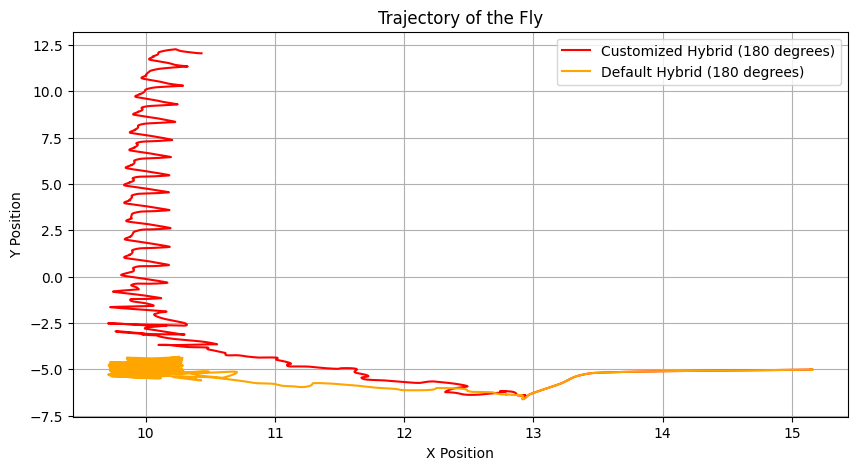

In [21]:
# plot all the trajectories to compare the two controllers
plt.figure(figsize=(10, 5))

plt.plot(np.array([obs["fly"][0] for obs in obs_hist_walls[150:]])[:, 0], np.array([obs["fly"][0] for obs in obs_hist_walls[150:]])[:, 1], label="Customized Hybrid (180 degrees)", color='red')
plt.plot(np.array([obs["fly"][0] for obs in obs_hist_walls_dft[150:]])[:, 0], np.array([obs["fly"][0] for obs in obs_hist_walls_dft[150:]])[:, 1], label="Default Hybrid (180 degrees)", color='orange')

plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Trajectory of the Fly")
plt.grid(True)
plt.legend()
plt.show()